# Week 4: Predicting the next word

Welcome to this assignment! During this week you saw how to create a model that will predict the next word in a text sequence, now you will implement such model and train it using a corpus of Shakespeare's sonnets, while also creating some helper functions to pre-process the data.


Let's get started!

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
import tensorflow as tf

For this assignment you will be using the [Shakespeare Sonnets Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), which contains more than 2000 lines of text extracted from Shakespeare's sonnets.

In [ ]:
# sonnets.txt
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 98.5MB/s]


In [ ]:
# Define path for file with sonnets
SONNETS_FILE = './sonnets.txt'

# Read the data
with open('./sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


## Tokenizing the text

Now fit the Tokenizer to the corpus and save the total number of words.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

When converting the text into sequences you can use the `texts_to_sequences` method as you have done throughout this course.

In the next graded function you will need to process this corpus one line at a time. Given this, it is important to keep in mind that the way you are feeding the data unto this method affects the result. Check the following example to make this clearer.

The first example of the corpus is a string and looks like this:

In [ ]:
corpus[0]

'from fairest creatures we desire increase,'

If you pass this text directly into the `texts_to_sequences` method you will get an unexpected result:

In [ ]:
tokenizer.texts_to_sequences(corpus[0])

[[],
 [],
 [58],
 [],
 [],
 [],
 [17],
 [6],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 []]

This happened because `texts_to_sequences` expects a list and you are providing a string. However a string is still and `iterable` in Python so you will get the word index of every character in the string.

Instead you need to place the example whithin a list before passing it to the method:

In [ ]:
tokenizer.texts_to_sequences([corpus[0]])

[[34, 417, 877, 166, 213, 517]]

Notice that you received the sequence wrapped inside a list so in order to get only the desired sequence you need to explicitly get the first item in the list like this:

In [ ]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[34, 417, 877, 166, 213, 517]

## Generating n_grams

Now complete the `n_gram_seqs` function below. This function receives the fitted tokenizer and the corpus (which is a list of strings) and should return a list containing the `n_gram` sequences for each line in the corpus:

In [ ]:
# GRADED FUNCTION: n_gram_seqs
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences
    
    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    
    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []
    
    ### START CODE HERE
    
    for line in corpus:
      token_list = tokenizer.texts_to_sequences([line])[0]
      for i in range(1,len(token_list)):
        n_gram_seq = token_list[:i+1]
        input_sequences.append(n_gram_seq)

    ### END CODE HERE
    
    return input_sequences

In [ ]:
# Test your function with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

**Expected Output:**

```
n_gram sequences for first example look like this:

[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]
```

In [ ]:
# Test your function with a bigger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311],
 [25, 311, 635],
 [25, 311, 635, 102],
 [25, 311, 635, 102, 200],
 [25, 311, 635, 102, 200, 25],
 [25, 311, 635, 102, 200, 25, 278]]

**Expected Output:**

```
n_gram sequences for next 3 examples look like this:

[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311],
 [25, 311, 635],
 [25, 311, 635, 102],
 [25, 311, 635, 102, 200],
 [25, 311, 635, 102, 200, 25],
 [25, 311, 635, 102, 200, 25, 278]]
```

Apply the `n_gram_seqs` transformation to the whole corpus and save the maximum sequence length to use it later:

In [ ]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length 
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


**Expected Output:**

```
n_grams of input_sequences have length: 15462
maximum length of sequences is: 11
```

## Add padding to the sequences

Now code the `pad_seqs` function which will pad any given sequences to the desired maximum length. Notice that this function receives a list of sequences and should return a numpy array with the padded sequences: 

In [ ]:
# GRADED FUNCTION: pad_seqs
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to the same length
    
    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences
    
    Returns:
        padded_sequences (array of int): tokenized sequences padded to the same length
    """
    ### START CODE HERE
    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen)
    
    return padded_sequences
    ### END CODE HERE

In [ ]:
# Test your function with the n_grams_seq of the first example
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]], dtype=int32)

**Expected Output:**

```
array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]], dtype=int32)
```

In [ ]:
# Test your function with the n_grams_seq of the next 3 examples
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]], dtype=int32)

**Expected Output:**

```
array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]], dtype=int32)
```

In [ ]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


**Expected Output:**

```
padded corpus has shape: (15462, 11)
```

## Split the data into features and labels

Before feeding the data into the neural network you should split it into features and labels. In this case the features will be the padded n_gram sequences with the last word removed from them and the labels will be the removed word.

Complete the `features_and_labels` function below. This function expects the padded n_gram sequences as input and should return a tuple containing the features and the one hot encoded labels.

Notice that the function also receives the total of words in the corpus, this parameter will be very important when one hot enconding the labels since every word in the corpus will be a label at least once. If you need a refresh of how the `to_categorical` function works take a look at the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)

In [ ]:
# GRADED FUNCTION: features_and_labels
def features_and_labels(input_sequences, total_words):
    """
    Generates features and labels from n-grams
    
    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size
    
    Returns:
        features, one_hot_labels (array of int, array of int): arrays of features and one-hot encoded labels
    """
    ### START CODE HERE
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, total_words)
    ### END CODE HERE

    return features, one_hot_labels

In [ ]:
# Test your function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (5, 3211)

features look like this:



array([[  0,   0,   0,   0,  34],
       [  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213]], dtype=int32)

**Expected Output:**

```
labels have shape: (5, 3211)

features look like this:

array([[  0,   0,   0,   0,  34],
       [  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213]], dtype=int32)
```

In [ ]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


**Expected Output:**

```
features have shape: (15462, 10)
labels have shape: (15462, 3211)
```

## Create the model

Now you should define a model architecture capable of achieving an accuracy of at least 80%.

Some hints to help you in this task:

- An appropriate `output_dim` for the first layer (Embedding) is 100, this is already provided for you.
- A Bidirectional LSTM is helpful for this particular problem.
- The last layer should have the same number of units as the total number of words in the corpus and a softmax activation function.
- This problem can be solved with only two layers (excluding the Embedding) so try out small architectures first.

In [ ]:
from keras.backend import categorical_crossentropy
# GRADED FUNCTION: create_model
def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model
    
    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences
    
    Returns:
        model (tf.keras Model): the text generator model
    """
    model = Sequential()
    ### START CODE HERE
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(Bidirectional(LSTM(50)))
    model.add(Dense(total_words/2, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(Dense(total_words, activation='softmax'))
    # Compile the model
    model.compile(loss=categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
    
    ### END CODE HERE

    return model

In [ ]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 26s 29ms/step - loss: 6.8120 - accuracy: 0.0213
Epoch 2/50
484/484 [==============================] - 7s 14ms/step - loss: 6.4479 - accuracy: 0.0307
Epoch 3/50
484/484 [==============================] - 6s 13ms/step - loss: 6.2580 - accuracy: 0.0357
Epoch 4/50
484/484 [==============================] - 7s 14ms/step - loss: 6.0729 - accuracy: 0.0406
Epoch 5/50
484/484 [==============================] - 6s 12ms/step - loss: 5.8416 - accuracy: 0.0496
Epoch 6/50
484/484 [==============================] - 7s 14ms/step - loss: 5.6031 - accuracy: 0.0617
Epoch 7/50
484/484 [==============================] - 6s 12ms/step - loss: 5.3731 - accuracy: 0.0750
Epoch 8/50
484/484 [==============================] - 6s 13ms/step - loss: 5.1381 - accuracy: 0.0878
Epoch 9/50
484/484 [==============================] - 6s 12ms/step - loss: 4.9040 - accuracy: 0.1044
Epoch 10/50
484/484 [==============================] - 7s 14ms/step - loss: 4.6605 - accur

**To pass this assignment, your model should achieve a training accuracy of at least 80%**. If your model didn't achieve this threshold, try training again with a different model architecture, consider increasing the number of unit in your `LSTM` layer.

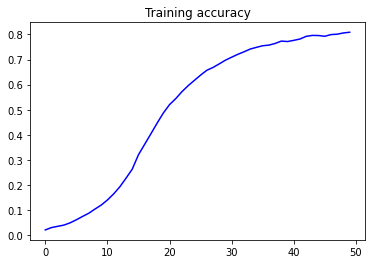

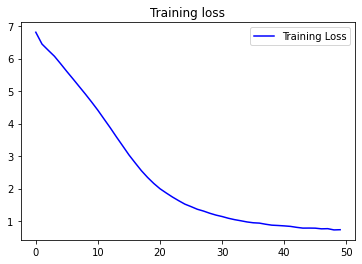

In [ ]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

Before closing the assignment, be sure to also download the `history.pkl` file which contains the information of the training history of your model and will be used to compute your grade. You can download this file by running the cell below:

In [ ]:
def download_history():
  import pickle
  from google.colab import files

  with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## See your model in action

After all your work it is finally time to see your model generating text. 

Run the cell below to generate the next 100 words of a seed text.

After submitting your assignment you are encouraged to try out training for different amounts of epochs and seeing how this affects the coherency of the generated text. Also try changing the seed text to see what you get!

In [ ]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	# Convert the text into sequences
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	# Pad the sequences
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# Get the probabilities of predicting a word
	predicted = model.predict(token_list, verbose=0)
	# Choose the next word based on the maximum probability
	predicted = np.argmax(predicted, axis=-1).item()
	# Get the actual word from the word index
	output_word = tokenizer.index_word[predicted]
	# Append to the current text
	seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope to show a rest waste of thee the sun of truth than decease groan face seen of love of love thee well so more eyes in my tongue is that the sun of truth and held groan ' doth seeming thee live no tomb the tomb the ocean is ride pleasure wrong of truth with rolling rolling grow sad gone days with ill sight in it friend not thee so sun so bad my state ' in mine eye aside aside in mine eye ' born in the self same sky sky seen wrongs the night with day with day


You will also need to submit this notebook for grading. To download it, click on the File tab in the upper left corner of the screen then click on Download -> Download .ipynb. You can name it anything you want as long as it is a valid .ipynb (jupyter notebook) file.

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of predicting the next word in a sequence of text!

**We hope to see you in the next course of the specialization! Keep it up!**